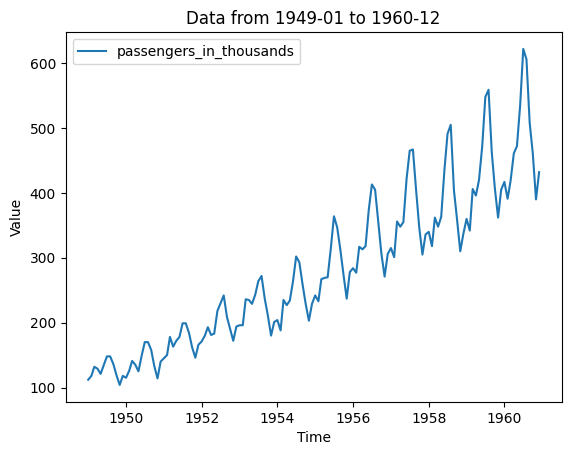

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/airline/airline.csv')

def plot_csv_by_time(csv_path, start_time, end_time):
    # Load CSV file into a pandas dataframe
    df = pd.read_csv(csv_path,parse_dates=['Month'],  index_col=['Month'])
    
    # Select rows within the specified time range
    df = df.loc[start_time:end_time]
    
    # Generate a line plot for each column in the dataframe
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    
    # Set plot title and axis labels
    plt.title(f"Data from {start_time} to {end_time}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    
    # Display legend and show plot
    plt.legend()
    plt.show()


plot_csv_by_time('data/airline/airline.csv', '1949-01', '1960-12')

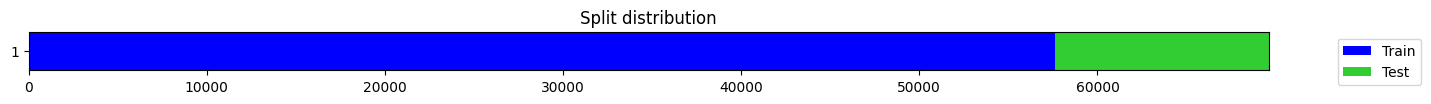

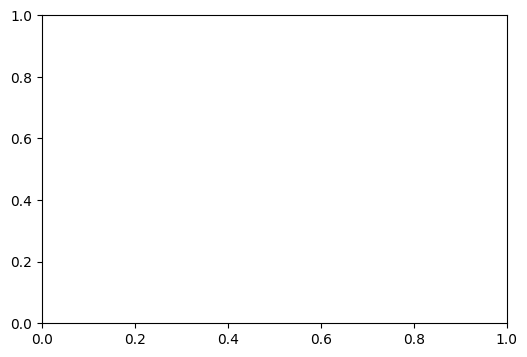

KeyboardInterrupt: 

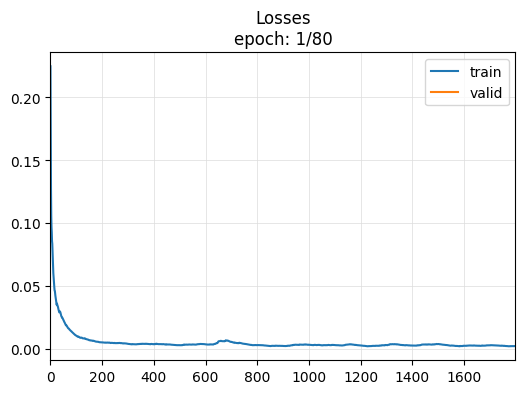

In [17]:
from tsai.basics import *
import pandas as pd

df = pd.read_csv('data/ETTm1/ETTm1.csv')
df = df['OT']
df = (df - df.min())/(df.max() - df.min())
ts = df.values.astype(float)

X, y = SlidingWindow(72, horizon=1)(ts)
splits = TimeSplitter(12000)(y) 
tfms = [None, TSForecasting()]
batch_tfms = TSStandardize()
fcst = TSForecaster(X, y, splits=splits, path='models', tfms=tfms, batch_tfms=batch_tfms, bs=32, arch="TSTPlus", metrics=mae, cbs=ShowGraph())
fcst.fit_one_cycle(80, 1e-3)
fcst.export("fcst.pkl")

In [10]:
X.shape

(120, 1, 24)

In [11]:
y.shape

(120,)

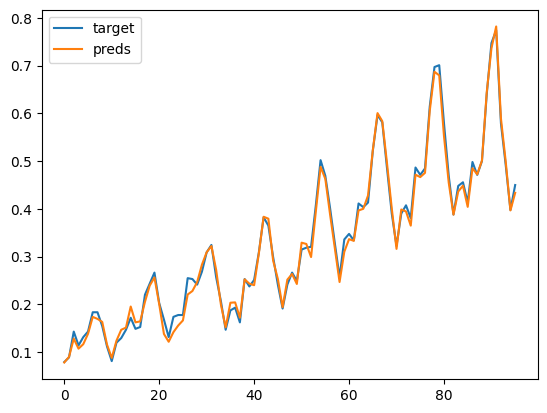

In [14]:
raw_preds, target, preds = fcst.get_X_preds(X[splits[0]], y[splits[0]])
import matplotlib.pyplot as plt

plt.plot(target, label='target')
plt.plot(preds, label='preds')
plt.legend()
plt.show()

In [8]:
target.shape

torch.Size([14925, 24])

In [142]:
raw_preds.squeeze()

tensor([0.0654, 0.0714, 0.0813, 0.0903, 0.0939, 0.0952, 0.1009, 0.1049, 0.1005,
        0.0905, 0.0773, 0.0697, 0.0771, 0.0907, 0.1026, 0.1182, 0.1235, 0.1367,
        0.1405, 0.1400, 0.1316, 0.1173, 0.1068, 0.1086, 0.1218, 0.1394, 0.1606,
        0.1710, 0.1780, 0.1814, 0.1985, 0.1982, 0.1924, 0.1686, 0.1536, 0.1509,
        0.1667, 0.1856, 0.2020, 0.2341, 0.2607, 0.2774, 0.2767, 0.2719, 0.2506,
        0.2215, 0.2002, 0.1934, 0.2146, 0.2453, 0.2713, 0.3084, 0.3209, 0.3341,
        0.3463, 0.3448, 0.3025, 0.2542, 0.2161, 0.2053, 0.2277, 0.2646, 0.3089,
        0.3507, 0.3848, 0.4072, 0.4320, 0.4297, 0.3819, 0.3275, 0.2861, 0.2713,
        0.3106, 0.3495, 0.3931, 0.4514, 0.4867, 0.5196, 0.5570, 0.5463, 0.4947,
        0.4192, 0.3612, 0.3469, 0.3774, 0.4171, 0.4542, 0.5221, 0.5596, 0.5941,
        0.6379, 0.6360, 0.5815, 0.4889, 0.4166, 0.3850, 0.4070, 0.4385, 0.4703,
        0.5300, 0.5659, 0.6132, 0.6753, 0.6999, 0.6592, 0.5359, 0.4529, 0.4038])

In [82]:
X[splits[1]]

array([[[0.40733591, 0.38030888, 0.48648649, 0.47104247, 0.48455598,
         0.61389961, 0.6969112 , 0.7007722 , 0.57915058, 0.46911197,
         0.38803089, 0.44787645, 0.45559846, 0.41312741, 0.4980695 ,
         0.47104247, 0.5       , 0.63899614, 0.74710425, 0.77413127,
         0.57915058, 0.49227799, 0.3976834 , 0.44980695]],

       [[0.38030888, 0.48648649, 0.47104247, 0.48455598, 0.61389961,
         0.6969112 , 0.7007722 , 0.57915058, 0.46911197, 0.38803089,
         0.44787645, 0.45559846, 0.41312741, 0.4980695 , 0.47104247,
         0.5       , 0.63899614, 0.74710425, 0.77413127, 0.57915058,
         0.49227799, 0.3976834 , 0.44980695, 0.49420849]],

       [[0.48648649, 0.47104247, 0.48455598, 0.61389961, 0.6969112 ,
         0.7007722 , 0.57915058, 0.46911197, 0.38803089, 0.44787645,
         0.45559846, 0.41312741, 0.4980695 , 0.47104247, 0.5       ,
         0.63899614, 0.74710425, 0.77413127, 0.57915058, 0.49227799,
         0.3976834 , 0.44980695, 0.49420849, 0.45945

In [79]:
y[1]

0.0888030888030888

In [77]:
ts

array([0.01544402, 0.02702703, 0.05405405, 0.04826255, 0.03281853,
       0.05984556, 0.08494208, 0.08494208, 0.06177606, 0.02895753,
       0.        , 0.02702703, 0.02123552, 0.04247104, 0.07142857,
       0.05984556, 0.04054054, 0.08687259, 0.12741313, 0.12741313,
       0.1042471 , 0.05598456, 0.01930502, 0.06949807, 0.07915058,
       0.08880309, 0.14285714, 0.11389961, 0.13127413, 0.14285714,
       0.18339768, 0.18339768, 0.15444015, 0.11196911, 0.08108108,
       0.11969112, 0.12934363, 0.14671815, 0.17181467, 0.14864865,
       0.15250965, 0.22007722, 0.24324324, 0.26640927, 0.2027027 ,
       0.16795367, 0.13127413, 0.17374517, 0.17760618, 0.17760618,
       0.25482625, 0.25289575, 0.24131274, 0.26833977, 0.30888031,
       0.32432432, 0.25675676, 0.20656371, 0.14671815, 0.18725869,
       0.19305019, 0.16216216, 0.25289575, 0.23745174, 0.25096525,
       0.30888031, 0.38223938, 0.36486486, 0.2992278 , 0.24131274,
       0.19111969, 0.24131274, 0.26640927, 0.24903475, 0.31467

In [78]:
X[1]

array([[0.02702703, 0.05405405, 0.04826255, 0.03281853, 0.05984556,
        0.08494208, 0.08494208, 0.06177606, 0.02895753, 0.        ,
        0.02702703, 0.02123552, 0.04247104, 0.07142857, 0.05984556,
        0.04054054, 0.08687259, 0.12741313, 0.12741313, 0.1042471 ,
        0.05598456, 0.01930502, 0.06949807, 0.07915058]])

In [47]:
import torch 
import pandas as pd

from src.forecast_models import LSTMForecaster
from src.dataset import TimeSeriesDataset
from src.train import train, inference 
from src.scaler import Scaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df = pd.read_csv('data/airline/airline.csv')
input_field = ['passengers_in_thousands']
output_field = ['passengers_in_thousands']

lr = 1e-4
batch_size = 32
epochs = 20

t = 24
ns = 1
hs = 256

train_end_index = int(0.8 * len(df))
train_df = df[:train_end_index].reset_index()
val_df = df[train_end_index:].reset_index()

field_to_be_scaled = list(set(input_field+output_field))
#scaler = Scaler(train_df[field_to_be_scaled])
#trainSet = TimeSeriesDataset(train_df, input_field, output_field, t = t, scaler = scaler)
#valSet = TimeSeriesDataset(val_df, input_field, output_field, t = t, scaler = scaler)

trainSet = TimeSeriesDataset(train_df, input_field, output_field, t = t)
valSet = TimeSeriesDataset(val_df, input_field, output_field, t = t)

model = LSTMForecaster(input_size=1, output_size=1, hidden_size=hs, num_layers=ns,  dropout=0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
criteria = torch.nn.L1Loss()

for epoch in range(epochs):
    train_loss = train(model=model, train_set = trainSet,
                       optimizer = optimizer, criterion = criteria, 
                       batch_size = batch_size, device=device)
    val_loss = inference(model=model, testSet=valSet, 
                        criterion=criteria, batch_size=batch_size,
                        device=device)
    print("Epoch: {}, train loss: {:.4f}, val loss: {:.4f}".format(epoch, train_loss, val_loss))

KeyboardInterrupt: 

In [44]:
model(trainSet[90][0].unsqueeze(0))

tensor([[476.0912]], grad_fn=<AddmmBackward0>)

In [45]:
for i in range(len(trainSet)):
    print(model(trainSet[i][0].unsqueeze(0)).item())

455.96466064453125
415.35736083984375
479.8455810546875
480.51678466796875
426.382568359375
439.7617492675781
450.29791259765625
442.05377197265625
438.3128662109375
491.31414794921875
472.2965087890625
420.8809814453125
486.952392578125
469.5335998535156
426.09075927734375
472.3023376464844
437.98602294921875
427.6900329589844
422.1385192871094
491.29425048828125
457.73309326171875
424.86309814453125
457.633056640625
464.0365905761719
469.4727783203125
452.951904296875
469.6414489746094
451.5908508300781
454.955322265625
468.7186279296875
438.9040832519531
486.8526611328125
484.47882080078125
478.53033447265625
455.91058349609375
480.78985595703125
466.12628173828125
446.6575927734375
491.6612243652344
442.0398254394531
484.7206115722656
466.2852478027344
422.09051513671875
447.1662902832031
461.0074157714844
453.05572509765625
454.2022705078125
400.4129943847656
435.39385986328125
432.65179443359375
452.9002685546875
459.33642578125
470.1393737792969
510.24285888671875
409.3336791992

In [12]:
for epoch in range(3):
    train_loss = train(model=model, train_set = trainSet,
                       optimizer = optimizer, criterion = criteria, 
                       batch_size = batch_size, device=device)
    val_loss = inference(model=model, testSet=valSet, 
                        criterion=criteria, batch_size=batch_size,
                        device=device)
    print("Epoch: {}, train loss: {:.4f}, val loss: {:.4f}".format(epoch, train_loss, val_loss))

Epoch: 0, train loss: 0.2895, val loss: 0.2101
Epoch: 1, train loss: 0.2167, val loss: 0.3080


KeyboardInterrupt: 

In [3]:
field_to_be_scaled

['a', 'i', 'g', 'd', 'p', 't', 'h', '_', 'e', 'u', 'r', 'o', 's', 'n']

In [2]:
field_to_be_scaled

['a', 'i', 'g', 'd', 'p', 't', 'h', '_', 'e', 'u', 'r', 'o', 's', 'n']

In [17]:
temp = df[:train_end_index].reset_index()

In [4]:
df.head()

,Month,passengers_in_thousands
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [23]:
import torch
import pandas as pd
from src.utils import load_checkpoint
from src.scaler import Scaler
from src.dataset import TimeSeriesDataset
from src.forecast_strategy import LSTMStrategy
from src.train import train, inference

input_field = ['passengers_in_thousands']
output_field = ['passengers_in_thousands']
timeseries_field = list(set(input_field + output_field))
datasetPath = 'data/airline/airline.csv'
modelPath = 'out/LSTMForecaster_airline/n1_hs16_t18/best.pth.tar'

n=1
hs=16
t=18

strategy = LSTMStrategy(modelPath, num_layers=n, hidden_size=hs, lookback_length=t)
strategy.load_data(datasetPath)
df = strategy.forecast(input_field, output_field, 12)

=> loaded checkpoint 'True' (epoch 4238)
Checkpoint's train loss is: 0.0540
Checkpoint's validation loss is: 0.0078


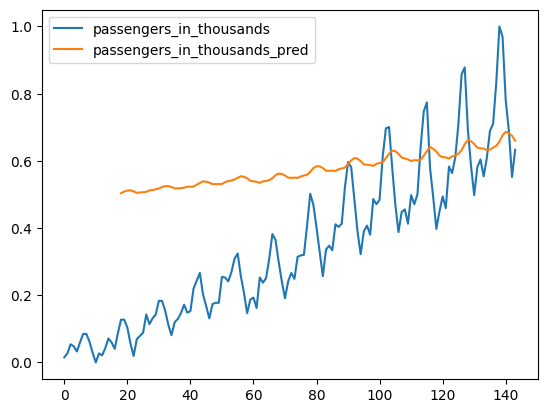

In [24]:
import matplotlib.pyplot as plt

cols = ['passengers_in_thousands', 'passengers_in_thousands_pred']
for col in cols:
    plt.plot(df[col], label=col)
plt.legend()
plt.show()